# GROUP REPORT: Classification of Hazardous/Nonhazardous Nearest Earth Objects (NEOs)

<p>Section: 008<br>
Group: 34<br>
Authors: Philip Chen, Liam Guetg, Vanesse Li, Ada Jiang</p>

### Introduction

A near-earth object (NEO) is an asteroid or comet with an orbit that approaches a point within 1.3 astronomical units of the sun.<sup>[1](#1)</sup> The JPL Center for NEO Studies conducts research on these objects by computing orbits and assessing the impact risk (of collision) of individual NEOs over time.<sup>[3](#1)</sup>

In this project, we want to expand the JPL's research. To determine the impact risk of a NEO, we must predict its trajectory by studying observable attributes.<sup>[2](#1)</sup> However, NEOs are irregularly shaped and are constantly moving, so measurements are estimates are taken at various times, distances and phase angles.<sup>[3](#1)</sup> Considering this imperfect data, we want to create an effective binary classifier that uses the K-nearest neighbours algorithm to predict whether a given NEO is harmful or not based on various quantitative measurements. A NEO's hazardous designation changes based on updated trajectory predictions, so it is more important that our classifier correctly identify a hazardous NEO as hazardous (i.e., have high recall) than prevent false positives.<sup>[3](#1)</sup>. Our question is, which predictors and what K value will produce a classifier that predicts a NEO's hazardous designation with the highest accuracy and recall?

#### NEO Dataset
This dataset compiles the list of NASA certified asteroids that are classified as NEOs.<sup>[4](#1)</sup>

1. **id** (unique identifier for each asteroid)
2. **name** (name of asteroid given by NASA)
3. **est_diameter_min** (minimum estimated diameter in kilometres)
4. **est_diameter_max** (maximum estimated diameter in kilometres)
5. **relative_velocity** (velocity relative to earth, units unknown)
6. **miss_distance** (distance in kilometres missed)
7. **orbiting_body** (planet that the asteroid orbits)
8. **sentry_object** (included in JPL Sentry System?)
9. **absolute_magnitude** (intrinsic mean brightness)<sup>[5](#1)</sup>
10. **hazardous** (boolean factor that indicates whether asteroid is harmful or not)

### Preliminary exploratory data analysis

To begin with the project, we install the packages and libraries necessary to perform the analysis.

In [1]:
# Run this cell before continuing
install.packages("cowplot")
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# Run this cell before continuing
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(kknn)
library(shiny)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

### Methods and Results Part 1: Exploratory Data Analysis (EDA)

Below, we read the data through the database on the URL (Table 1) and convert hazardous into a categorical variable.

In [3]:
# reading in data from remote source
url <- "https://raw.githubusercontent.com/LongTortue/DSCI100-Group-Project/main/neo.csv"
neo_data <- read_csv(url)

# transforming the intended response variable into a categorical variable, then viewing the dataset
neo_data <- neo_data |>
mutate(hazardous = as_factor(hazardous))
head(neo_data)
h4("Table 1: Initial dataset")

Rows: 90836 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): name, orbiting_body
dbl (6): id, est_diameter_min, est_diameter_max, relative_velocity, miss_dis...
lgl (2): sentry_object, hazardous

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<fct>
2162635,162635 (2000 SS164),1.19827080,2.67941497,13569.25,54839744,Earth,FALSE,16.73,FALSE
2277475,277475 (2005 WK4),0.26580000,0.59434687,73588.73,61438127,Earth,FALSE,20.00,TRUE
2512244,512244 (2015 YE18),0.72202956,1.61450717,114258.69,49798725,Earth,FALSE,17.83,FALSE
3596030,(2012 BV13),0.09650615,0.21579430,24764.30,25434973,Earth,FALSE,22.20,FALSE
3667127,(2014 GE35),0.25500869,0.57021676,42737.73,46275567,Earth,FALSE,20.09,TRUE
54138696,(2021 GY23),0.03635423,0.08129053,34297.59,40585691,Earth,FALSE,24.32,FALSE


Shiny tags cannot be represented in plain text (need html)

is.na() is used to check for missing values in the data set - of which there are none.

In [4]:
# Counting the number of observations with "N/A" values
neo_na_count <- sum(is.na(neo_data))
print(paste("Number of observations that are missing data values: ", neo_na_count))
# no missing values in our dataset

[1] "Number of observations that are missing data values:  0"


Grouping by orbiting body and counting the observations, we ensure all observations have an orbiting body of Earth (Table 2), as we are not concerned with the well being of other planets. :)

In [5]:
# Checking if all observations contain NEOs orbiting Earth, as relevant to our research question
neo_count_orbiting <- neo_data |>
    group_by(orbiting_body) |>
    summarize(count = n())
neo_count_orbiting # all observations have orbiting bodies of Earth
h4("Table 2: Total number of observations and orbiting body")

orbiting_body,count
<chr>,<int>
Earth,90836


Shiny tags cannot be represented in plain text (need html)

Grouping by hazardous and counting the number of observations in each class, we notice severe imbalance (Table 3). An imbalanced data set will create bias in our algorithm since there are more points of one category to act as neighbors, thus giving it more voting power.

In [6]:
# Counting the number of observations in each class
neo_count_data <- neo_data|>
    group_by(hazardous)|>
    summarize(count = n())
neo_count_data
h4("Table 3: Count of observations in each class")

hazardous,count
<fct>,<int>
FALSE,81996
TRUE,8840


Shiny tags cannot be represented in plain text (need html)

To work around this, we oversample the True class, generating a new balanced dataframe with 400 observations of each hazardous class randomly selected from the original dataset. A seed is set for this process to ensure reproducibility. 

However, the potential drawback of balancing our data this way would be that our classifier is trained using far fewer observations than the number of observations in the original dataset. Randomly selecting observations does not ensure that our training dataset is representative of the real data. If the selected observations within each hazardous class are very close to each other, the model would have an easier time classifying the hazardous class of NEOs which could lead to artificially high recall and precision values.

We then split the balanced data frame into a training set and a testing set with a 75%/25% split.  

In [7]:
set.seed(1) # added a seed to make the results reproducible

# as the data is unbalanced, we will create a new dataset that is balanced,
# with limitations that will be expanded upon in the corresponding methods section
neo_data_false <- neo_data |>
    filter(hazardous == "FALSE") |>
    sample_n(400)
neo_data_true <- neo_data |>
    filter(hazardous == "TRUE") |>
    sample_n(400)
neo_data_balanced <- rbind(neo_data_false, neo_data_true) # balanced dataset

# splitting the balanced dataset into training and testing splits to be used 
# to train and evaluate our model
neo_data_split <- initial_split(neo_data_balanced, prop = 0.75, strata = hazardous)
neo_data_train <- training(neo_data_split)
neo_data_test <- testing(neo_data_split)

To get a better grasp of the data we are dealing with, the mean value of each predictor variable is calculated on the training set. It seems that hazardous NEOs are associated with higher estimated diameters, faster relative velocity, larger miss distance and lower absolute magnitude (Table 4 and 5). 

In [8]:
# Calculating the mean average value for hazardous vs non-hazardous NEOs
neo_mean_hazardous_true <- neo_data_train |>
    filter(hazardous == "TRUE") |>
    select(-id, -name, -orbiting_body, -sentry_object, -hazardous) |>
    map_df(mean)
neo_mean_hazardous_true # mean of predictors for TRUE hazardous observations
h4("Table 4: Mean value of each variable for hazardous observations")

neo_mean_hazardous_false <- neo_data_train |>
    filter(hazardous == "FALSE") |>
    select(-id, -name, -orbiting_body, -sentry_object, -hazardous) |>
    map_df(mean)
neo_mean_hazardous_false # mean of predictors for TRUE hazardous observations
h4("Table 5: Mean value of each variable for non-hazardous observations")

est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3148544,0.7040357,63125.47,41221246,20.24423


Shiny tags cannot be represented in plain text (need html)

est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1064974,0.2381355,47520.97,37928703,24.0061


Shiny tags cannot be represented in plain text (need html)

Distribution graphs of each variable are also plotted as a histogram and coloured according to its hazardous class. We notice the varying distribution and huge difference in scale between the predictor variables (Fig. 1-5), so step_scale and step_center are required to scale the predictor values. This ensures that the values of one predictor variable does not overpower the other variables in training the k-nearest neighbours algorithm in our model.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


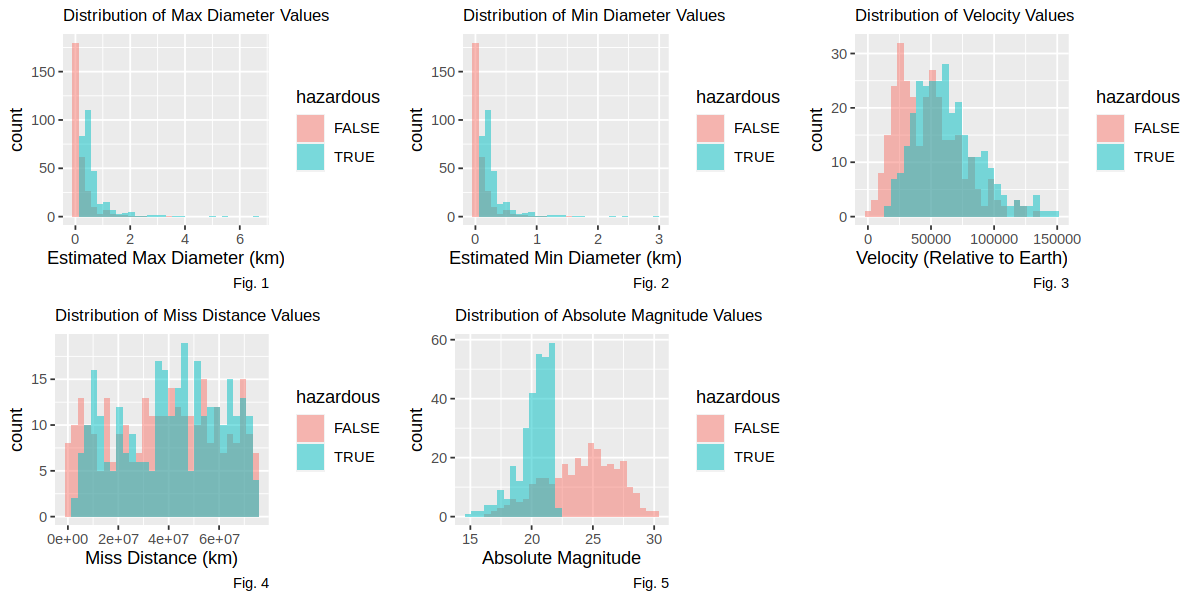

In [9]:
options(repr.plot.width = 10, repr.plot.height = 5)
# plots visualizing distribution of data, and shown next to each other
neo_plot_max_diameter <- neo_data_train |>
    ggplot(aes(x = est_diameter_max, fill = hazardous)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    xlab("Estimated Max Diameter (km)") +
    ggtitle("Distribution of Max Diameter Values") +
    labs(caption = "Fig. 1") +
    theme(plot.title = element_text(size = 10))

neo_plot_min_diameter <- neo_data_train |>
    ggplot(aes(x = est_diameter_min, fill = hazardous)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    xlab("Estimated Min Diameter (km)") +
    ggtitle("Distribution of Min Diameter Values") +
    labs(caption = "Fig. 2") +
    theme(plot.title = element_text(size = 10))

neo_plot_velocity <- neo_data_train |>
    ggplot(aes(x = relative_velocity, fill = hazardous)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    xlab("Velocity (Relative to Earth)") +
    ggtitle("Distribution of Velocity Values") +
    labs(caption = "Fig. 3") +
    theme(plot.title = element_text(size = 10))

neo_plot_miss_distance <- neo_data_train |>
    ggplot(aes(x = miss_distance, fill = hazardous)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    xlab("Miss Distance (km)") +
    ggtitle("Distribution of Miss Distance Values") +
    labs(caption = "Fig. 4") +
    theme(plot.title = element_text(size = 10))

neo_plot_abs_magnitude <- neo_data_train |>
    ggplot(aes(x = absolute_magnitude, fill = hazardous)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    xlab("Absolute Magnitude") +
    ggtitle("Distribution of Absolute Magnitude Values") +
    labs(caption = "Fig. 5") +
    theme(plot.title = element_text(size = 10))

plot_grid(neo_plot_max_diameter, neo_plot_min_diameter, neo_plot_velocity, 
          neo_plot_miss_distance, neo_plot_abs_magnitude)

### Methods and Results Part 2: Data Analysis

A standardization recipe is created using the training data set. The JPL Sentry System (a reliable automated collision monitory system) uses these variables to calculate impact risk and predicted threat<sup>[6](#1)</sup>: 
1. est_diameter_min
2. est_diameter_max
3. relative_velocity
4. miss_distance
5. absolute_magnitude

Based on this fact, we believe that there is correlation between these variables and the hazardous class of a NEO. In addition, the distribution visualizations in the EDA (Fig. 1-5) demonstrate that miss distance values do not show much correlation towards a hazardous group because there is no clear trend in the histogram. As such, we will be using all variables except miss_distance as predictors in our classifier.

A recipe is created that uses the aforementioned variables as predictors and assigns hazardous variable as the response, as well as center and scale the predictors.

In order to determine the best k value, a k-nearest neighbour model and a 5-fold cross-validation set is created and tuned using k values from 2-30. We choose to test up to k = 30 so that the cost of training the model is not too expensive. A workflow is then created to yield a table with k values and their corresponding accuracy score (Table 6).

In [10]:
set.seed(50) # added a seed to make the results reproducible

# Create a recipe
neo_recipe <- recipe(hazardous ~ est_diameter_min + est_diameter_max + 
                     relative_velocity + absolute_magnitude, data = neo_data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Create a nearest_neighbors model specification
neo_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Cross validation using stratification to generate different variations of the model
neo_vfold <- vfold_cv(neo_data_train, v = 5, strata = hazardous)

# Combine the recipe and model in workflow, train and tune classifier
k_vals <- tibble(neighbors = seq(2, 30))

knn_results <- workflow() |>
    add_recipe(neo_recipe) |>
    add_model(neo_model) |>
    tune_grid(resamples = neo_vfold, grid = k_vals) |>
    collect_metrics()
head(knn_results)
h4("Table 6: Collected metrics")

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8283333,5,0.01359126,Preprocessor1_Model01
2,roc_auc,binary,0.8684167,5,0.01166151,Preprocessor1_Model01
3,accuracy,binary,0.8300000,5,0.01740051,Preprocessor1_Model02
3,roc_auc,binary,0.8789444,5,0.01625965,Preprocessor1_Model02
4,accuracy,binary,0.8300000,5,0.01740051,Preprocessor1_Model03
4,roc_auc,binary,0.8821111,5,0.01838111,Preprocessor1_Model03


Shiny tags cannot be represented in plain text (need html)

We then plot a graph of k values versus the accuracy estimate created by cross-validation to determine the best k value (Fig. 6). 

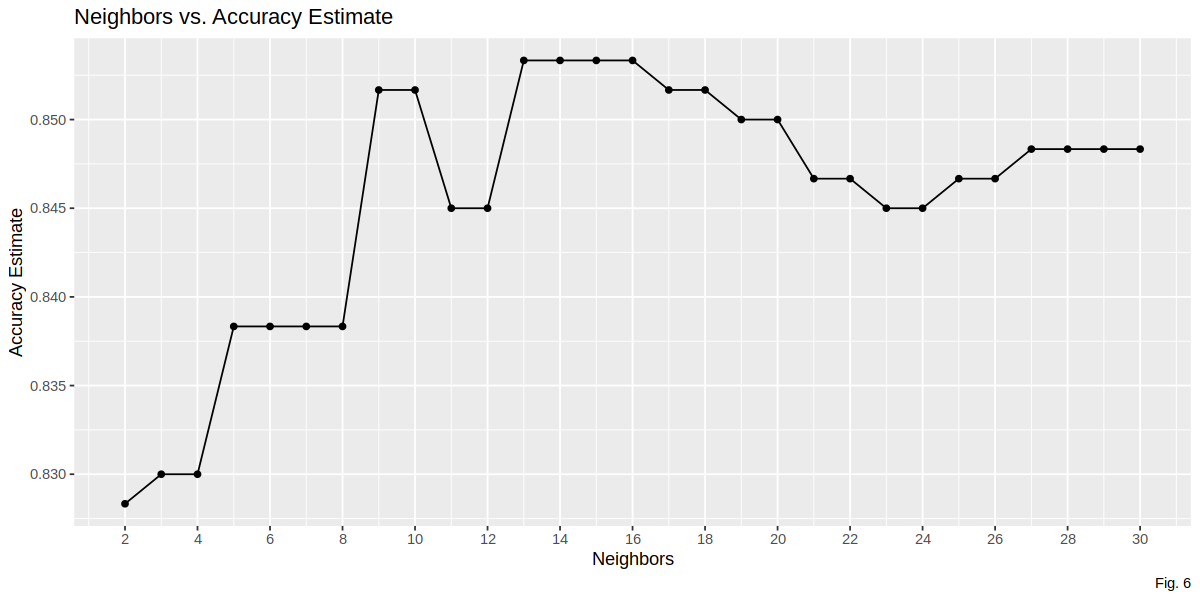

In [11]:
options(repr.plot.width = 10, repr.plot.height = 5)
# Visualize the results
accuracies <- knn_results |>
    filter(.metric == "accuracy")

results_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Neighbors vs. Accuracy Estimate") +
    labs(caption = "Fig. 6") +
    scale_x_continuous(breaks = seq(0, 30, by = 2))
results_plot

Based on the plot, we can see that k = 13 to k = 16 have equivalent accuracy scores and are the highest scores overall. We choose to use k = 14 because the variation in accuracy score from k = 14 to 15 is lower compared to that of k = 13 to 14. We also decide to use k = 15 for a similar reason as changing the k value to a nearby one (k = 14 or 16) doesn't decrease accuracy too much.

For each of the proposed best k values, a new nearest neighbour model is created. The training set is then fit into a new workflow using the new model but the same recipe previously used.

The classifier is then tested using the testing set. We then bind the column of predicted hazardous class to the testing set.

We then calculate the accuracy level using the metrics() function, comparing between .pred_class (prediction) and hazardous (truth). See Table 7 for k = 14 and Table 8 for k = 15.

A confusion matrix is generated to calculate the precision and recall of our algorithm to assess its performance. See Fig. 7 for k = 14 and Fig. 8 for k = 15.

We use format() to round the performance scores to 4 decimal places, and then display the calculated precision and recall values.

In [12]:
set.seed(50) # added a seed to make the results reproducible

# Setting classifer to use k = 14
neo_model_best_14 <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
    set_engine("kknn") |>
    set_mode("classification")

neo_fit_14 <- workflow() |>
    add_recipe(neo_recipe) |>
    add_model(neo_model_best_14) |>
    fit(data = neo_data_train)

neo_predictions_14 <- predict(neo_fit_14, neo_data_test) |>
    bind_cols(neo_data_test)

neo_metrics_14 <- neo_predictions_14 |>
    metrics(truth = hazardous, estimate = .pred_class)
slice(neo_metrics_14, 1)
h4("Table 7: Accuracy of classifier using k = 14")

neo_conf_mat_14 <- neo_predictions_14 |>
    conf_mat(truth = hazardous, estimate = .pred_class)
neo_conf_mat_14
h4("Fig. 7: Confusion matrix of classifier using k = 14")

precision_14 = format(round(99/(99 + 1), 4), nsmall=4)
print(paste("Precision:", precision_14))

recall_14 = format(round(99/(99 + 24), 4), nsmall=4)
print(paste("Recall:", recall_14))

# Setting classifier to use k = 15
neo_model_best_15 <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
    set_engine("kknn") |>
    set_mode("classification")

neo_fit_15 <- workflow() |>
    add_recipe(neo_recipe) |>
    add_model(neo_model_best_15) |>
    fit(data = neo_data_train)

neo_predictions_15 <- predict(neo_fit_15, neo_data_test) |>
    bind_cols(neo_data_test)

neo_metrics_15 <- neo_predictions_15 |>
    metrics(truth = hazardous, estimate = .pred_class)
slice(neo_metrics_15, 1)
h4("Table 8: Accuracy of classifier using k = 15")

neo_conf_mat_15 <- neo_predictions_15 |>
    conf_mat(truth = hazardous, estimate = .pred_class)
neo_conf_mat_15
h4("Fig. 8: Confusion matrix of classifier using k = 15")

precision_15 = format(round(99/(99 + 1), 4), nsmall=4)
print(paste("Precision:", precision_15))

recall_15 = format(round(99/(99 + 25), 4), nsmall=4)
print(paste("Recall:", recall_15))

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.875


Shiny tags cannot be represented in plain text (need html)

          Truth
Prediction FALSE TRUE
     FALSE    76    1
     TRUE     24   99

Shiny tags cannot be represented in plain text (need html)

[1] "Precision: 0.9900"
[1] "Recall: 0.8049"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.87


Shiny tags cannot be represented in plain text (need html)

          Truth
Prediction FALSE TRUE
     FALSE    75    1
     TRUE     25   99

Shiny tags cannot be represented in plain text (need html)

[1] "Precision: 0.9900"
[1] "Recall: 0.7984"


### Discussion

We set out to identify which predictors and what K value will produce a classifier that predicts a NEOs hazardous class with the highest accuracy and recall. In our exploratory data analysis, we plotted potential predictors on separate histograms to visualize the distribution of hazardous and non-hazardous NEOs for each individual predictor (Fig. 1-5). Our results showed that the only predictor with significant overlap was miss distance (Fig. 4). While the other predictors didn’t show significant overlap, indicating their potential as valid predictors to determine if an unknown NEO is either hazardous (true) or not hazardous (false). Hence our findings indicated that the best predictors to use for this classification analysis are the NEOs' minimum estimated diameter (km), maximum estimated diameter (km), velocity relative to earth and its intrinsic brightness (absolute magnitude).  This was not an expected finding since the JPL Sentry System, a reliable predictor for hazardous NEOs, uses miss distance as a predictor <sup>[6](#1)</sup>. In addition, we would think that the miss distance (i.e., how close the NEO gets to the orbiting body) would be correlated with the potential of a NEO to collide with the Earth. However, to keep the project more manageable we decided to focus on optimizing the k value.

As per the methods, we then used these predictors to create a binary classification algorithm in order to predict whether a NEO is hazardous or not. Accounting for the differences in scale, mean values and distribution of observations we standardized the predictors and ensured the data was balanced in terms of hazardous class. We then used cross-validation to determine the K-value(s) with an optimal accuracy score. Our analysis showed that the highest accuracy was obtained by the K-values from 13 to 16 (Fig. 6). We concluded that 14 and 15 were the best k-value to use as there was less variation in accuracy when changing to nearby K-values (Fig. 6). 

By creating and comparing two models (one for each proposed K-value) we were able to generate a model using K = 14 with an accuracy of 87.5% (Table 7). This is a relatively high accuracy, indicating that our model is a capable algorithm with the ability to distinguish between hazardous and non-hazardous NEOs. This score supports the pattern we observed in the EDA: variables involved in NEO trajectory and speed are correlated to the likelihood of the NEO causing a dangerous collision. We hypothesize that the accuracy score would be lower if we included miss distance in the recipe step, as miss distance is difficult to measure and would not be a reliable predictor of hazardous level of a NEO<sup>[6](#1)</sup>.

Through further analysis we determined that our model had a recall score of 99.0% and a precision score of 80.5%. Recall indicates the proportion of hazardous NEOs that were successfully predicted to be hazardous while the precision value indicates the proportion of predicted hazardous NEOs that were actually hazardous. Since both values are relatively high, our model proves to be capable in differentiating between hazardous and non-hazardous NEOs. Furthermore, since the recall is higher than the precision, our model appears to be more likely to indicate a false positive (predicting a harmless NEO as hazardous) than a false negative. This is an acceptable trade-off because of the nature of what we are predicting: NEOs can have devastating and potentially fatal consequences in the event of a collision and hence it is better to have more false positives than to have false negatives which could potentially hit earth if not identified in time.

These findings will have an impact on everyone's safety on Earth. With a reliable classification model, as demonstrated by our accuracy, precision, and recall, we can determine whether a NEO poses a significant risk to the planet before any collision occurs. Being able to classify an object's hazardousness through observable attributes allows us to be ready ahead of time and minimize potential damage. To improve our model, further analysis can focus on different combinations of predictors, or new predictors, that may improve the accuracy of our model.  Additionally, researchers may want to investigate ways to redirect the trajectory of an Earth-bound object and analyze alternative protective measures to minimize potential harm <sup>[7](#1)</sup>.

<a id="1"></a> 
### References
1. *Keeping an eye on Space Rocks.* (n.d.) NASA/JPL Caltech. https://www.jpl.nasa.gov/keeping-an-eye-on-space-rocks
2. *NEO Basics.* (n.d.) NASA/JPL CNEOS. https://cneos.jpl.nasa.gov/about/target_earth.html
3. *Impact Risk.* (n.d.) NASA/JPL CNEOS. https://cneos.jpl.nasa.gov/risk/intro.html
4. Vani, Sameep. *NASA - Nearest Earth Objects.* (n.d.) Kaggle. Retrieved October 26, 2023, from https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects
5. *Discovery Statistics.* (n.d.) NASA/JPL CNEOS. https://cneos.jpl.nasa.gov/stats/
6. *Sentry: Earth Impact Monitoring.* (n.d.) NASA/JPL CNEOS. https://cneos.jpl.nasa.gov/sentry/
7. Tedesco, Edward. *Earth impact hazard.* (n.d.) Britannica. https://www.britannica.com/science/Earth-impact-hazard/Determining-the-hazard-potential-of-an-NEO